# 3. Domaći zadatak - Spam sms classification

Studenti: Milica Spasić - br. indeksa 1207, Irena Đorđević - br. indeksa 1048

Za treći domaći izabran je sledeći skup podataka: https://www.kaggle.com/uciml/sms-spam-collection-dataset. 
Cilj je utvrditi da li je sms spam ili ne.

In [1]:
import numpy as np
import pandas as pd 

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation
from tensorflow.keras.layers import Embedding
from tensorflow.keras.layers import Conv1D, GlobalMaxPooling1D
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing import sequence
from sklearn.preprocessing import LabelEncoder
from sklearn import metrics as skl_metrics
import time
from tensorflow.keras import metrics
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

import matplotlib
import matplotlib.pyplot as plt

Učitavanje i preprocesiranje podataka

Izbačene su kolone koje ne nose nikakvu informaciju.

In [2]:
data_path = "spam.csv"
df = pd.read_csv(data_path,encoding='latin-1')
print(df.head())

data = df.drop(["Unnamed: 2", "Unnamed: 3", "Unnamed: 4"], axis=1)
data = data.rename(columns={"v1":'label', "v2":'text'})
print(data.head())
tags = data["label"]
texts = data["text"]

     v1                                                 v2 Unnamed: 2  \
0   ham  Go until jurong point, crazy.. Available only ...        NaN   
1   ham                      Ok lar... Joking wif u oni...        NaN   
2  spam  Free entry in 2 a wkly comp to win FA Cup fina...        NaN   
3   ham  U dun say so early hor... U c already then say...        NaN   
4   ham  Nah I don't think he goes to usf, he lives aro...        NaN   

  Unnamed: 3 Unnamed: 4  
0        NaN        NaN  
1        NaN        NaN  
2        NaN        NaN  
3        NaN        NaN  
4        NaN        NaN  
  label                                               text
0   ham  Go until jurong point, crazy.. Available only ...
1   ham                      Ok lar... Joking wif u oni...
2  spam  Free entry in 2 a wkly comp to win FA Cup fina...
3   ham  U dun say so early hor... U c already then say...
4   ham  Nah I don't think he goes to usf, he lives aro...


In [3]:
tags

0        ham
1        ham
2       spam
3        ham
4        ham
        ... 
5567    spam
5568     ham
5569     ham
5570     ham
5571     ham
Name: label, Length: 5572, dtype: object

In [4]:
texts

0       Go until jurong point, crazy.. Available only ...
1                           Ok lar... Joking wif u oni...
2       Free entry in 2 a wkly comp to win FA Cup fina...
3       U dun say so early hor... U c already then say...
4       Nah I don't think he goes to usf, he lives aro...
                              ...                        
5567    This is the 2nd time we have tried 2 contact u...
5568                Will Ì_ b going to esplanade fr home?
5569    Pity, * was in mood for that. So...any other s...
5570    The guy did some bitching but I acted like i'd...
5571                           Rofl. Its true to its name
Name: text, Length: 5572, dtype: object

In [5]:
data.describe()

,label,text
count,5572,5572
unique,2,5169
top,ham,"Sorry, I'll call later"
freq,4825,30


In [6]:
data.groupby('label').describe()

text                                                               
      count unique                                                top freq
label                                                                     
ham    4825   4516                             Sorry, I'll call later   30
spam    747    653  Please call our customer service representativ...    4

Labele je potrebno enkodirati (0 i 1). 

In [7]:
# convert label to a numerical variable
data['label_num'] = data.label.map({'ham':0, 'spam':1})
data.head()

,label,text,label_num
0,ham,"Go until jurong point, crazy.. Available only ...",0
1,ham,Ok lar... Joking wif u oni...,0
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,1
3,ham,U dun say so early hor... U c already then say...,0
4,ham,"Nah I don't think he goes to usf, he lives aro...",0


In [8]:
data['message_len'] = data.text.apply(len)
data.head()

,label,text,label_num,message_len
0,ham,"Go until jurong point, crazy.. Available only ...",0,111
1,ham,Ok lar... Joking wif u oni...,0,29
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,1,155
3,ham,U dun say so early hor... U c already then say...,0,49
4,ham,"Nah I don't think he goes to usf, he lives aro...",0,61


Text(0.5, 0, 'Message Length')

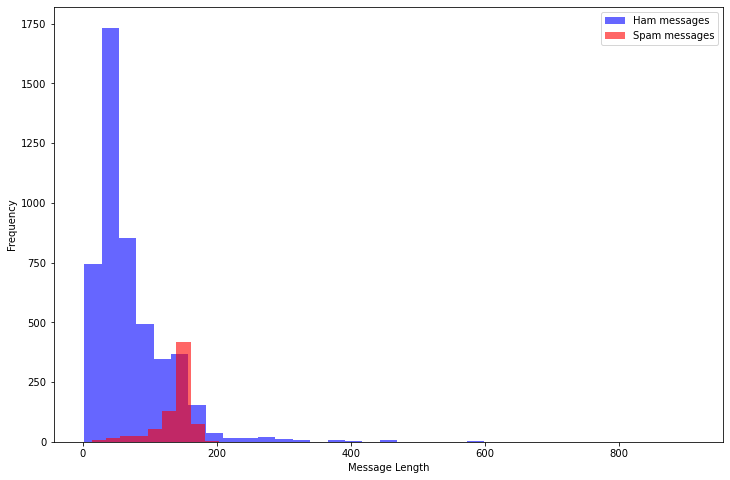

In [9]:
plt.figure(figsize=(12, 8))

data[data.label=='ham'].message_len.plot(bins=35, kind='hist', color='blue', 
                                       label='Ham messages', alpha=0.6)
data[data.label=='spam'].message_len.plot(kind='hist', color='red', 
                                       label='Spam messages', alpha=0.6)
plt.legend()
plt.xlabel("Message Length")

Ovde je interesantno zapaziti trend da spam poruke imaju uglavnom više karaktera.

In [10]:
data[data.label=='ham'].describe()

,label_num,message_len
count,4825.0,4825.000000
mean,0.0,71.023627
std,0.0,58.016023
min,0.0,2.000000
25%,0.0,33.000000
50%,0.0,52.000000
75%,0.0,92.000000
max,0.0,910.000000


In [11]:
data[data.label=='spam'].describe()

,label_num,message_len
count,747.0,747.000000
mean,1.0,138.866131
std,0.0,29.183082
min,1.0,13.000000
25%,1.0,132.500000
50%,1.0,149.000000
75%,1.0,157.000000
max,1.0,224.000000


In [12]:
data[data.message_len == 910].text.iloc[0]

"For me the love should start with attraction.i should feel that I need her every time around me.she should be the first thing which comes in my thoughts.I would start the day and end it with her.she should be there every time I dream.love will be then when my every breath has her name.my life should happen around her.my life will be named to her.I would cry for her.will give all my happiness and take all her sorrows.I will be ready to fight with anyone for her.I will be in love when I will be doing the craziest things for her.love will be when I don't have to proove anyone that my girl is the most beautiful lady on the whole planet.I will always be singing praises for her.love will be when I start up making chicken curry and end up makiing sambar.life will be the most beautiful then.will get every morning and thank god for the day because she is with me.I would like to say a lot..will tell later.."

Maksimalan broj karatktera u jednom tekstu ćemo ograničiti na 1000, obzirom da je najveća dužina teksta nađena da bude 910. 
I tekstove je potrebno predstaviti u obliku (tokenizacijom, matrično) razumljivom neuronskoj mreži.

In [13]:
num_max = 1000
tags = data['label_num']
tok = Tokenizer(num_words=num_max)
tok.fit_on_texts(texts)
mat_texts = tok.texts_to_matrix(texts,mode='count')

In [14]:
tags

0       0
1       0
2       1
3       0
4       0
       ..
5567    1
5568    0
5569    0
5570    0
5571    0
Name: label_num, Length: 5572, dtype: int64

In [15]:
mat_texts

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 3., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 1., 1., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.]])

Nakon toga vršimo podelu dataseta na train i test setove.

In [16]:
x_train,x_test,y_train,y_test = train_test_split(texts,tags, test_size = 0.3)
mat_texts_tr = tok.texts_to_matrix(x_train,mode='count')
mat_texts_tst = tok.texts_to_matrix(x_test,mode='count')

Sada ćemo definisati jednostavan model sa malo skrivenih slojeva.
Loss funkcija koje se koristi je binary cross-entropy, dok je optimizator Adam. 
Metrika na osnovu koje će se meriti performanse našeg modela u trening fazi i fazi validacije, u ovom koraku, jeste tačnost.

In [17]:
def get_simple_model(loss='binary_crossentropy'):
    model = Sequential()
    model.add(Dense(512, activation='relu', input_shape=(num_max,)))
    model.add(Dropout(0.2))
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(1, activation='sigmoid'))
    model.summary()
    if loss == "hinge":
        loss = tf.keras.losses.Hinge()
    elif loss == "squared_hinge":
        loss = tf.keras.losses.SquaredHinge()
    model.compile(loss=loss,optimizer='adam',metrics=['acc',metrics.binary_accuracy])
    return model

In [18]:
def check_model(model,xtr,ytr,xts,yts):
    model.fit(xtr,ytr,batch_size=32,epochs=10,verbose=1,validation_split=0.3)
    print(' ')
    model.evaluate(xts,yts)

In [19]:
m = get_simple_model()
check_model(m,mat_texts_tr,y_train,mat_texts_tst,y_test)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 512)               512512    
_________________________________________________________________
dropout (Dropout)            (None, 512)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 256)               131328    
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 257       
Total params: 644,097
Trainable params: 644,097
Non-trainable params: 0
_________________________________________________________________
Train on 2730 samples, validate on 1170 samples
Epoch 1/10
2730/2730 [==============================] - 2s 566us/sam

In [20]:
y_pred = m.predict(mat_texts_tst)

In [21]:
y_pred_tresh = []

for num in y_pred:
    if num <= 0.5:
        y_pred_tresh.append([0])
    else:
        y_pred_tresh.append([1])

In [22]:
y_pred

array([[1.5744003e-05],
       [1.6036191e-05],
       [4.1211221e-09],
       ...,
       [6.0055368e-03],
       [6.5221045e-10],
       [2.2247671e-11]], dtype=float32)

In [23]:
y_pred_tresh

[[0],
 [0],
 [0],
 [0],
 [1],
 [0],
 [0],
 [0],
 [1],
 [0],
 [0],
 [1],
 [0],
 [0],
 [0],
 [0],
 [1],
 [0],
 [1],
 [0],
 [0],
 [1],
 [0],
 [0],
 [0],
 [0],
 [0],
 [0],
 [0],
 [0],
 [0],
 [0],
 [1],
 [0],
 [0],
 [0],
 [1],
 [0],
 [0],
 [0],
 [0],
 [0],
 [1],
 [0],
 [0],
 [0],
 [1],
 [0],
 [0],
 [0],
 [0],
 [0],
 [0],
 [0],
 [0],
 [0],
 [0],
 [0],
 [0],
 [0],
 [1],
 [0],
 [0],
 [0],
 [0],
 [0],
 [0],
 [1],
 [0],
 [0],
 [0],
 [0],
 [0],
 [0],
 [0],
 [1],
 [0],
 [0],
 [0],
 [0],
 [0],
 [0],
 [0],
 [0],
 [0],
 [0],
 [0],
 [0],
 [0],
 [0],
 [1],
 [0],
 [0],
 [0],
 [0],
 [0],
 [0],
 [1],
 [0],
 [0],
 [0],
 [0],
 [0],
 [0],
 [0],
 [0],
 [0],
 [0],
 [0],
 [0],
 [1],
 [0],
 [1],
 [0],
 [0],
 [0],
 [0],
 [0],
 [0],
 [0],
 [0],
 [0],
 [0],
 [0],
 [0],
 [0],
 [0],
 [0],
 [0],
 [0],
 [0],
 [0],
 [0],
 [0],
 [0],
 [0],
 [0],
 [0],
 [0],
 [0],
 [0],
 [0],
 [0],
 [0],
 [1],
 [0],
 [0],
 [0],
 [0],
 [0],
 [0],
 [0],
 [0],
 [0],
 [0],
 [0],
 [1],
 [0],
 [0],
 [0],
 [0],
 [0],
 [0],
 [1],
 [0],
 [0],
 [0]

In [24]:
print('Confusion Matrix')
print(confusion_matrix(y_test, y_pred_tresh))

Confusion Matrix
[[1446    3]
 [  22  201]]


Sada ćemo proveriti tačnost na test setu.

In [25]:
skl_metrics.f1_score(y_test, y_pred_tresh)

0.9414519906323185

Sada ćemo isprobati isti model, ali sa drugom loss funkcijom, koja je takođe namenjena da se koristi u slučajevima binarne klasifikacije, tzv. Hinge loss.

In [26]:
m = get_simple_model(loss="hinge")
check_model(m,mat_texts_tr,y_train,mat_texts_tst,y_test)

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              (None, 512)               512512    
_________________________________________________________________
dropout_2 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 256)               131328    
_________________________________________________________________
dropout_3 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 257       
Total params: 644,097
Trainable params: 644,097
Non-trainable params: 0
_________________________________________________________________
Train on 2730 samples, validate on 1170 samples
Epoch 1/10
2730/2730 [==============================] - 1s 289us/s

In [27]:
y_pred = m.predict(mat_texts_tst)

In [28]:
y_pred_tresh = []

for num in y_pred:
    if num <= 0.5:
        y_pred_tresh.append([0])
    else:
        y_pred_tresh.append([1])

In [29]:
y_pred

array([[1.2249283e-06],
       [3.6007603e-07],
       [3.6429189e-12],
       ...,
       [4.9396967e-05],
       [8.7666635e-10],
       [4.7234748e-13]], dtype=float32)

In [30]:
y_pred_tresh

[[0],
 [0],
 [0],
 [0],
 [1],
 [0],
 [0],
 [0],
 [1],
 [0],
 [0],
 [1],
 [0],
 [0],
 [0],
 [0],
 [1],
 [0],
 [1],
 [0],
 [0],
 [1],
 [0],
 [0],
 [0],
 [0],
 [0],
 [0],
 [0],
 [0],
 [1],
 [0],
 [1],
 [0],
 [0],
 [0],
 [1],
 [0],
 [0],
 [0],
 [0],
 [0],
 [1],
 [0],
 [0],
 [0],
 [1],
 [0],
 [0],
 [0],
 [0],
 [0],
 [0],
 [0],
 [0],
 [0],
 [0],
 [0],
 [0],
 [0],
 [1],
 [0],
 [0],
 [0],
 [0],
 [0],
 [0],
 [1],
 [0],
 [0],
 [0],
 [0],
 [0],
 [0],
 [0],
 [1],
 [0],
 [0],
 [0],
 [0],
 [0],
 [0],
 [0],
 [0],
 [0],
 [0],
 [1],
 [0],
 [0],
 [0],
 [1],
 [0],
 [0],
 [0],
 [0],
 [0],
 [0],
 [1],
 [0],
 [0],
 [0],
 [0],
 [0],
 [0],
 [0],
 [0],
 [0],
 [0],
 [0],
 [0],
 [1],
 [0],
 [1],
 [0],
 [0],
 [0],
 [0],
 [0],
 [0],
 [0],
 [0],
 [0],
 [0],
 [0],
 [0],
 [0],
 [0],
 [0],
 [0],
 [0],
 [0],
 [0],
 [0],
 [0],
 [0],
 [0],
 [0],
 [0],
 [0],
 [0],
 [0],
 [0],
 [0],
 [0],
 [1],
 [0],
 [0],
 [0],
 [0],
 [0],
 [0],
 [0],
 [0],
 [0],
 [0],
 [0],
 [1],
 [0],
 [0],
 [0],
 [0],
 [0],
 [0],
 [1],
 [0],
 [0],
 [0]

In [31]:
print('Confusion Matrix')
print(confusion_matrix(y_test, y_pred_tresh))

Confusion Matrix
[[1446    3]
 [  14  209]]


In [32]:
skl_metrics.f1_score(y_test, y_pred_tresh)

0.9609195402298851

Poboljšanje je vidno iako je i inicijalni rezultat bio odličan. Sada ćemo probati još jednu loss funkciju, Squared Hinge loss.

In [33]:
m = get_simple_model(loss="squared_hinge")
check_model(m,mat_texts_tr,y_train,mat_texts_tst,y_test)

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_6 (Dense)              (None, 512)               512512    
_________________________________________________________________
dropout_4 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_7 (Dense)              (None, 256)               131328    
_________________________________________________________________
dropout_5 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_8 (Dense)              (None, 1)                 257       
Total params: 644,097
Trainable params: 644,097
Non-trainable params: 0
_________________________________________________________________
Train on 2730 samples, validate on 1170 samples
Epoch 1/10
2730/2730 [==============================] - 1s 331us/s

In [34]:
y_pred = m.predict(mat_texts_tst)

In [35]:
y_pred_tresh = []

for num in y_pred:
    if num <= 0.5:
        y_pred_tresh.append([0])
    else:
        y_pred_tresh.append([1])

In [36]:
y_pred

array([[3.4631846e-06],
       [6.2476147e-07],
       [4.2197854e-09],
       ...,
       [8.8069390e-04],
       [1.3588017e-10],
       [1.3848989e-10]], dtype=float32)

In [37]:
y_pred_tresh

[[0],
 [0],
 [0],
 [0],
 [1],
 [0],
 [0],
 [0],
 [1],
 [0],
 [0],
 [1],
 [0],
 [0],
 [0],
 [0],
 [1],
 [0],
 [1],
 [0],
 [0],
 [1],
 [0],
 [0],
 [0],
 [0],
 [0],
 [0],
 [0],
 [0],
 [1],
 [0],
 [1],
 [0],
 [0],
 [0],
 [1],
 [0],
 [0],
 [0],
 [0],
 [0],
 [1],
 [0],
 [0],
 [0],
 [1],
 [0],
 [0],
 [0],
 [0],
 [0],
 [0],
 [0],
 [0],
 [0],
 [0],
 [0],
 [0],
 [0],
 [1],
 [0],
 [0],
 [0],
 [0],
 [0],
 [0],
 [1],
 [0],
 [0],
 [0],
 [0],
 [0],
 [0],
 [0],
 [1],
 [0],
 [0],
 [0],
 [0],
 [0],
 [0],
 [0],
 [0],
 [0],
 [0],
 [0],
 [0],
 [0],
 [0],
 [1],
 [0],
 [0],
 [0],
 [0],
 [0],
 [0],
 [1],
 [0],
 [0],
 [0],
 [0],
 [0],
 [0],
 [0],
 [0],
 [0],
 [0],
 [0],
 [0],
 [1],
 [0],
 [1],
 [0],
 [0],
 [0],
 [0],
 [0],
 [0],
 [0],
 [0],
 [0],
 [0],
 [0],
 [0],
 [0],
 [0],
 [0],
 [0],
 [0],
 [0],
 [0],
 [0],
 [0],
 [0],
 [0],
 [0],
 [0],
 [0],
 [0],
 [0],
 [0],
 [0],
 [0],
 [1],
 [0],
 [0],
 [0],
 [0],
 [0],
 [0],
 [0],
 [0],
 [0],
 [0],
 [0],
 [0],
 [0],
 [0],
 [0],
 [0],
 [0],
 [0],
 [1],
 [0],
 [0],
 [0]

In [38]:
print('Confusion Matrix')
print(confusion_matrix(y_test, y_pred_tresh))

Confusion Matrix
[[1449    0]
 [  22  201]]


In [39]:
skl_metrics.f1_score(y_test, y_pred_tresh)

0.9481132075471698

Možemo videti da je i ova loss funkicja dobar izbor.

Sada možemo isprobati još jednostavniji model, ne bismo li videli da li će to dovesti do nekakvog pogoršanja rezulatata.

In [40]:
def get_simple_model_v2(loss='binary_crossentropy'):
    model = Sequential()
    model.add(Dense(128, activation='relu', input_shape=(num_max,)))
    model.add(Dropout(0.2))
    model.add(Dense(1, activation='sigmoid'))
    model.summary()
    if loss == "hinge":
        loss = tf.keras.losses.Hinge()
    elif loss == "squared_hinge":
        loss = tf.keras.losses.SquaredHinge()
    model.compile(loss=loss,optimizer='adam',metrics=['acc',metrics.binary_accuracy])
    return model

In [41]:
m = get_simple_model(loss="hinge")
check_model(m,mat_texts_tr,y_train,mat_texts_tst,y_test)

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_9 (Dense)              (None, 512)               512512    
_________________________________________________________________
dropout_6 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_10 (Dense)             (None, 256)               131328    
_________________________________________________________________
dropout_7 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_11 (Dense)             (None, 1)                 257       
Total params: 644,097
Trainable params: 644,097
Non-trainable params: 0
_________________________________________________________________
Train on 2730 samples, validate on 1170 samples
Epoch 1/10
2730/2730 [==============================] - 1s 279us/s

In [42]:
y_pred = m.predict(mat_texts_tst)

In [43]:
y_pred_tresh = []

for num in y_pred:
    if num <= 0.5:
        y_pred_tresh.append([0])
    else:
        y_pred_tresh.append([1])

In [44]:
y_pred

array([[6.2273220e-06],
       [2.0671159e-07],
       [2.5236471e-11],
       ...,
       [2.6271866e-05],
       [1.7987444e-09],
       [1.1201365e-12]], dtype=float32)

In [45]:
y_pred_tresh

[[0],
 [0],
 [0],
 [0],
 [1],
 [0],
 [0],
 [0],
 [1],
 [0],
 [0],
 [1],
 [0],
 [0],
 [0],
 [0],
 [1],
 [0],
 [1],
 [0],
 [0],
 [1],
 [0],
 [0],
 [0],
 [0],
 [0],
 [0],
 [0],
 [0],
 [0],
 [0],
 [1],
 [0],
 [0],
 [0],
 [1],
 [0],
 [0],
 [0],
 [0],
 [0],
 [1],
 [0],
 [0],
 [0],
 [1],
 [0],
 [0],
 [0],
 [0],
 [0],
 [0],
 [0],
 [0],
 [0],
 [0],
 [0],
 [0],
 [0],
 [1],
 [0],
 [0],
 [0],
 [0],
 [0],
 [0],
 [1],
 [0],
 [0],
 [0],
 [0],
 [0],
 [0],
 [0],
 [1],
 [0],
 [0],
 [0],
 [0],
 [0],
 [0],
 [0],
 [0],
 [0],
 [0],
 [0],
 [0],
 [0],
 [0],
 [1],
 [0],
 [0],
 [0],
 [0],
 [0],
 [0],
 [1],
 [0],
 [0],
 [0],
 [0],
 [0],
 [0],
 [0],
 [0],
 [0],
 [0],
 [0],
 [0],
 [1],
 [0],
 [1],
 [0],
 [0],
 [0],
 [0],
 [0],
 [0],
 [0],
 [0],
 [0],
 [0],
 [0],
 [0],
 [0],
 [0],
 [0],
 [0],
 [0],
 [0],
 [0],
 [0],
 [0],
 [0],
 [0],
 [0],
 [0],
 [0],
 [0],
 [0],
 [0],
 [0],
 [0],
 [1],
 [0],
 [0],
 [0],
 [0],
 [0],
 [0],
 [0],
 [0],
 [0],
 [0],
 [0],
 [1],
 [0],
 [0],
 [0],
 [0],
 [0],
 [0],
 [1],
 [0],
 [0],
 [0]

In [46]:
print('Confusion Matrix')
print(confusion_matrix(y_test, y_pred_tresh))

Confusion Matrix
[[1447    2]
 [  19  204]]


In [47]:
skl_metrics.f1_score(y_test, y_pred_tresh)

0.951048951048951

Rezultati su čak i za nijansu bolji. To nam samo govori da je za ovaj dataset bio dovoljan i mnogo jednostavniji model od inicijalnog, sa mnogo manje learnable parametara da uhvati pravilnost u podacima.